In [1]:
import os
os.getpid()

26374

In [2]:
list2 = []
file_data = open('amazon_review_50000.csv')
for row in file_data:
    list2.append(row)## Data pre-processing module
    
list3 = []
for i in range(len(list2)):
    list3.append((list2[i][-2],list2[i][:-3]))
    
lenth = len(list3)
train_list = list3[0:int(lenth*0.8)]
test_list = list3[int(lenth*0.8):]
print(len(test_list), len(train_list))
print(train_list[3000])

l = []
for i,j in list3:
    if i not in l:
        l.append(i)
print(l)

10000 40000
('5', '"I bought Tourmaline flat iron for my daughter in law for Christmas and they were on sale so I bought me one too. I couldn\'t believe the price. When I used it for the first time, my husband even noticed the difference. I was amazed how it made my hair feel as well as look. My daughter in law loves it as well. She\'s the one who made me get it in the first place. I would definitely recommend it above any flat irons I\'ve ever owned and I purchased it at the right time."')
['5', '4', '3', '1', '2']


In [3]:

import numpy as np

import torch
from torch.utils.data.sampler import BatchSampler, Sampler
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import random
from tqdm import tqdm

SEED=4321
random.seed(SEED)
np.random.seed(SEED)


class Corpora():
    """
    The class holds training and test corpora.
    """

    def __init__(self):
        """
        Constructor
        """
        # word to index (1-based integers) mapping
        self.word_index = {"N0O0N":0}
        # list of reviews tuples, each of which is (sentence_list, rate),
        self.training_reviews = []
        # (sentence_list, rate) Same format as training_sentences
        self.test_reviews = []

        self.max_len = 0


    # input: a tuple (reviewList, rate)
    # todo: insert values into fields
    # Return the list representing all index of words in a review.
    def insert_fields(self, input):   
        # Sentence list
        word_indexes = []
        for word in input:
            if word not in self.word_index.keys():
                self.word_index.update({word:len(self.word_index.keys())}) #No add 1 because 0 is already in
            # find the index of this word, add to return list
            word_indexes.append(self.word_index[word])
        if len(word_indexes)>self.max_len:
            self.max_len = len(word_indexes)
        return word_indexes
    
    
    
    
    # Different than P2, here we 
    def read_corpus(self, is_training):
        if is_training is True:
            target = train_list
        else:
            target = test_list
        print("reading corpus ...")
        for rate, text in tqdm(target):
            input = text.split(" ")
            tuple = (self.insert_fields(input), rate)
            if is_training: 
                self.training_reviews.append(tuple)
            else:
                self.test_reviews.append(tuple)
                    
                
# Inherient Dataset, convert list and int to tensors, load to GPU.
class ReviewRateDataset(Dataset):
   
    def __init__(self, review_rate_pairs): # NB: sequence_pairs is corpora.training_reviews, 
        # list of (sentence_list, rate)
        self.review_rate_pairs = review_rate_pairs

    def __len__(self):
        return len(self.review_rate_pairs)

    def __getitem__(self, idx):
        sentence_list, rate = self.review_rate_pairs[idx] 
        return torch.tensor(sentence_list), torch.tensor(int(rate))

# NB! This class will be in DataLoader function as a parameter for batch_sampler
class SortedBatchSampler(Sampler):
    """
        Each sequence in a mini-batch must of the same lengths, while our sentences
        are of various lengths.
        We can pad the sentences to the same lengths in each mini-batch.
        But if a short and long sentences are in the same mini-batch, more paddings
        are needed.
        We sort the sentences based on their lengths (in descending order)
            and then put sentences with similar lengths in a batch to reduce the paddings.
    """
    def __init__(self, dataset, batch_size):
        """
            dataset: an torch.utils.data.DataSet object containing all training sequences
            batch_size: the number of sequences to put in a mini-batch
        """

        # The sorting and batching go within this function.      
        self.batch_size = batch_size 
        # Sort the dataset (Based on the length of sentence.)
        dataset.review_rate_pairs  = sorted(dataset.review_rate_pairs,key=lambda x:len(x[0]), reverse=True)
        self.sorted_lengths = len(dataset)
        # Batching: Split the dataset into a list of datasets
        self.index_batches = []  
        # -- NB: Collate function does not work, so I pad it directly.
        for i in range(self.__len__()):
            self.index_batches.append(padding_collate_func(ReviewRateDataset(dataset.review_rate_pairs[i*batch_size:i*batch_size+batch_size])))
        # Now, each mini-batches is a ReviewRateDataset object
        # If else format is needed, may change it latter.
        
    def __iter__(self):
        """
            return a Python iterator object that iterates the mini-batchs of
                training data indices (not individual indices)
        """
        return iter(self.index_batches)

    def __len__(self):
        return self.sorted_lengths // self.batch_size

# NB! This function will be in DataLoader function as a parameter for collate_fn
def padding_collate_func(batch):
    """
        Transform pairs of input-output sequences in the batch to be of the same length using the function
            torch.nn.utils.rnn.pad_sequence.
        batch: An iterator and each element is a pair of (input_sequence, output_sequence).
        For POS tagging, len(input_sequence) = len(output_sequence). But for different
        pairs in batch, their lengths can differ.

        Example: a batch of 3 pairs of input/output sequences
                [([1,2,3],[1,1,1]), ([1,2,3,4],[2,2,2,2]), ([1,2,3,4,5],[3,3,3,3,3])]
                Note: [] encloses tensors (not numpy arra ys)
                
                
                !!!!!NB QUESTION:  it is the inner [] that encloses tensors, right?
                Comment: Batch is an element of a Sampler (see test_p1.py, a l[0] is a batch)
                
                
        return: two tensors (one for input sequence batch and another for output sequence batch).
                These tensors are padded with zeros so that all sequences in the same batch
                are of the same length.
        Example: input_sequence_batch = [[1,2,3,0,0], [1,2,3,4,0], [1,2,3,4,5]],
                 output_sequence_batch = [[1,1,1,0,0], [2,2,2,2,0], [3,3,3,3,3]]

    """
    ### Your codes go here (5 points) ###
    # Hint: read the article linked at the top of this cell.
    
    # NOTe
    # len(batch[0][0]) == len(batch.sequence_pairs[0]) == the target value (the maximum length for each batch)
    # I fill it might be easier to pad sequence_pairs with tuple (0,0), but let's see.
    
    # Doubles the memory takes by this batch, which is not good
    new_l = []
    rate = []
    for i,j in batch.review_rate_pairs:
        new_l.append( torch.tensor(i))
        rate.append( torch.tensor(int(j)))
    padded = pad_sequence(new_l, batch_first=True, padding_value=0)
    #print("len ", len(padded), len(rate)) #BUG: NEED ZIP HERE
    obj = ReviewRateDataset(list(zip(padded,rate)))
    # NB: For now the outter [] is neither tensor nor list, it is an obj!
    # Change latter if necessary
    # Yes, let's change it to two tensors return
    ret1 = []
    ret2 = []
    for i in obj:
        ret1.append(i[0])
        ret2.append(i[1])
    ret1 = torch.stack(ret1)
    ret2 = torch.stack(ret2)
    return ret1, ret2

In [4]:

from torch import embedding, nn
# There is really nothing to be stored in this object.
# -- But wait, how about self.rnn and self.fc?
# -- NB: NOW, I assume that the nn keep weights from the inherentance,
# -- And these functions as LSTM and FC will use these weight correctly
class LSTMScoreAssigner(nn.Module):
    def __init__(self, input_dim, output_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional):
        """
        :param input_dim: size of the vocabulary (number of unique tokens)
        :param output_dim: number of unique POS tags 
        :param emb_dim: embedding dimensionality of each token
        :param hid_dim: number of hidden neurons of a hidden state/cell
        :param n_layers: number of RNN layers (2 for faster training)
        :param dropout: dropout rate between 0 and 1at the embedding layer and rnn
        :param bidirectional: 1 if use bidirectional and 0 if don't
        """
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)

        # before output, there is a dropout (except the last layer)
        
        # -- Comment: this is a part of the analysis (last part of this hw)
        # -- It feels like I have no control on this bidirectional since it is part of nn library.
        if bidirectional == 0:
            self.rnn = nn.LSTM(input_size = emb_dim, hidden_size = hid_dim, num_layers = n_layers, dropout=dropout)
            self.fc = nn.Linear(hid_dim, output_dim)
            self.num_directions = 1
        elif bidirectional == 1:
            self.rnn = nn.LSTM(input_size = emb_dim, hidden_size = hid_dim, num_layers = n_layers, dropout=dropout, bidirectional=True)
            self.fc = nn.Linear(hid_dim * 2, output_dim)
            self.num_directions = 2

        self.dropout = nn.Dropout(dropout)

    # -- COMMENT
    # -- The src means sourse, which is a 2d array batch_size by sentence_len, it is a big 2d tensor
    # -- NBBBBB: How to turn the POSTaggedDataset into a big 2d tensor see test_p2 line 4-7
    def forward(self, src):
        """

        :param src: a [batch_size, sentence_len] array.
                     Each row is a sequence of word indices and each column represents a position in the sequence.
        :return: the predicted logits at each position. 
        """
        # -- src : a list of sentence tensors
        # -- logit : a tensor having length of self.output_dim
        
        
        ### Your codes go here (20 points) ###

        # Step 1: turn token indices into dense vector,
        # so that embedded is of shape (batch_size, sentence_len, emb_dim)
        src = self.embedding(src)
        # Step 2: rnn maps the tensor (batch_size, sentence_len, emb_dim) to
        # outputs = a tensor (batch_size, sentence_len, hid_dim)
        # hidden = a tensor (batch_size, sentence_len, hid_dim)
        # cell = a tensor (batch_size, sentence_len, hid_dim)
        
        # See library LSTM to continuw
        # Maybe find examples of LSTM
        
        # # Construct a h_0 and c_0
        # h_0 = 0
        # c_0 = 0
        
        # outputs, (hidden, cell) = self.rnn(self.embedding(src, (h_0, c_0)))
        # --- Come back from office hour
        output = self.rnn(src)[0]
        # The  self.rnn(src)[1] is a tuple of (h_n, c_n)
        # -- Think: is c_0 and h_0 necessary? I guess no for now.

        # Step 3: map the output tensor to a logit tensor of shape (batch_size, sentence_len, number_of_POS_tags)
        logit = self.fc(output)
        return torch.sum(logit, dim=1)/logit.shape[1]



In [5]:

from torch import optim
import time
import math

BATCH_SIZE = 16


corpora = Corpora()

corpora.read_corpus(True)
corpora.read_corpus(False)

print(f'Number of training sentences = {len(corpora.training_reviews)}')
print(f'Number of test sentences = {len(corpora.test_reviews)}')
print(f'Number of unique input tokens = {len(corpora.word_index)}')
print(f'Maximal sentence length = {corpora.max_len}')

print("\n\n Creating training Dataset, Sampler, and Iterators...")
training_dataset = ReviewRateDataset(corpora.training_reviews)
training_sampler = SortedBatchSampler(training_dataset, batch_size=BATCH_SIZE)
training_iterator = DataLoader(training_dataset,
                                  collate_fn = padding_collate_func,
                                  batch_sampler = training_sampler)
print("\n\n Creating test Dataset, Sampler, and Iterators")
test_dataset = ReviewRateDataset(corpora.test_reviews)
test_sampler = SortedBatchSampler(test_dataset, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_dataset,
                              collate_fn = padding_collate_func,
                              batch_sampler = test_sampler)


INPUT_DIM = len(corpora.word_index)
OUTPUT_DIM = 5
EMB_DIM = 256
HID_DIM = 5
N_LAYERS = 1 # number of LSTM layers.
BIDIRECT = 0 # 0: single direction (the default setting); 1: bidirectional
DROPOUT = 0.5
# initialize the model
ScoreAssigner = LSTMScoreAssigner(INPUT_DIM, OUTPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS, DROPOUT, BIDIRECT).cuda(3)



# Glove Embedding here?
def init_weights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

ScoreAssigner.apply(init_weights)

optimizer = optim.Adam(ScoreAssigner.parameters())

# we use 0 to represent padded POS tags and the loss function should ignore that.
# we calculate the sum of losses of pairs in each batch
PAD_INDEX = 0


# input: vector of [length, output_dim], integer (score)
criterion = nn.CrossEntropyLoss(reduction = 'sum', ignore_index = PAD_INDEX)



N_EPOCHS = 10
CLIP = 1

best_test_loss = float('inf')

training_losses = []
test_losses = []


reading corpus ...


100%|██████████| 40000/40000 [00:00<00:00, 44450.07it/s]


reading corpus ...


100%|██████████| 10000/10000 [00:00<00:00, 50209.36it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Number of training sentences = 40000
Number of test sentences = 10000
Number of unique input tokens = 114084
Maximal sentence length = 1379


 Creating training Dataset, Sampler, and Iterators...


 Creating test Dataset, Sampler, and Iterators


/home/jupyter-jiz322/.local/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [6]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -- The Iterator is a Dataloader object. 
# -- Use for loop in iterator.batch_sampler to access each batches
# -- In this case, each batches is having length 128

# -- Need to Figure out: The way to compute loss for RNN
def train(model, iterator, optimizer, criterion, clip):

    model.train()

    epoch_loss = 0
    num_batchs = 0
    total = 0

    # batch[0]: the word batch
    # batch[1]: the tag batch (target)
    for i, batch in enumerate(iterator.batch_sampler):
        num_batchs += 1
        z = ScoreAssigner.forward(batch[0].cuda(3))
        #a = torch.softmax(z,dim=-1)
        loss = 0
        # softmax of logit
        d = torch.softmax(z,dim=-1)
        # cross entropy loss of softmax and score
        loss=criterion(d,(batch[1]-1).cuda(3))/BATCH_SIZE
        loss.backward()
        # Clips gradient norm of an iterable of parameters.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        total += 1

    return epoch_loss /total

def evaluate(model, iterator, criterion):

    model.eval()
    epoch_loss = 0
    num_epochs = 0
    total = 0

    for i, batch in enumerate(iterator.batch_sampler):
        num_epochs += 1
        z = ScoreAssigner.forward(batch[0].cuda(3))
        loss = 0
        # softmax of logit
        d = torch.softmax(z,dim=-1)
        # cross entropy loss of softmax and score
        loss=criterion(d,(batch[1]-1).cuda(3))/BATCH_SIZE
        epoch_loss += loss.item()
        total += 1

    return epoch_loss/total

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs




In [7]:
for epoch in range(N_EPOCHS):  
    print("epoch start: ", epoch)  
    start_time = time.time()
    training_loss = train(ScoreAssigner, training_iterator, optimizer, criterion, CLIP)
    training_losses.append(training_loss)
    test_loss = evaluate(ScoreAssigner, test_iterator, criterion)
    test_losses.append(test_loss)  
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    if test_loss < best_test_loss:
        best_test_loss = test_loss 
        torch.save(ScoreAssigner.state_dict(), 'best_model.pt')
        

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s', end='')
    print(f'\tTrain Loss: {training_loss:.3f} | Test Loss: {test_loss:.3f}')

import pickle
with open(f'results/losses_L{N_LAYERS}_D{DROPOUT}_B{BIDIRECT}.pkl', 'wb') as f:
    pickle.dump({'training_losses': training_losses,
                'test_losses': test_losses}, f)

epoch start:  0
Epoch: 01 | Time: 0m 24s	Train Loss: 1.159 | Test Loss: 1.138
epoch start:  1
Epoch: 02 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138
epoch start:  2
Epoch: 03 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138
epoch start:  3
Epoch: 04 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138
epoch start:  4
Epoch: 05 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138
epoch start:  5
Epoch: 06 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138
epoch start:  6
Epoch: 07 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138
epoch start:  7
Epoch: 08 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138
epoch start:  8
Epoch: 09 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138
epoch start:  9
Epoch: 10 | Time: 0m 21s	Train Loss: 1.139 | Test Loss: 1.138


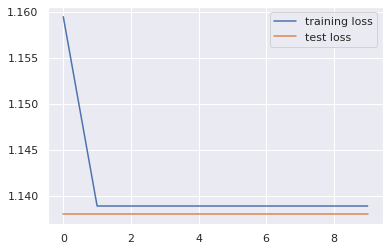

In [8]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.set()
x = np.arange(len(training_losses))
plt.plot(x, training_losses, label = 'training loss')
plt.plot(x, test_losses, label = 'test loss')
plt.legend()